# Baseball Data Pipelines

This file goes through an analytical pipeline of the Statcast baseball data collected from the `Data_Collection.ipynb` notebook. This file will detail a baseline performance using two methods: Logistic Regression and Decision Tree. These two models are specifically chosen for two main reasons: first is that they serve the role of "traditional models", and second is that they are, to an extent, interpretable. These two models, Logistic Regression and Decision Trees, will serve as a comparison in terms of performance and interpretability to models used in ***OTHER_NOTEBOOK***. The ultimate goal of this analytical project is utilize newer, more advanced modeling methods and extract knowledge with interpretation techniques. Thus, a benchmark needs to be established, both in terms of performance metrics (Accuracy, AUC, etc.) and interpretation power, in this case, coefficients and tree structure, to conclude that the proposed models and interpretation techniques do provide significant advantages over such traditional methods.

As such, the following will outline the process of this notebook. The main goals include: 
- Establish performance metrics for both models on raw data.
- Investigate interpretable aspects for both models. Explore the validity of such aspects
- Establish appropriate preprocessing steps to improve performance of models
- Re-evaluate models on processed data
- Investigate interpretable aspects on model built on processed data

## Outline of Notebook

Here is the outline of steps to be performed in this notebook.

1. Read in data.
    - Structure data as Pandas Dataframe
2. Ensure data quality
    - Investiate and remedy possible issues, such as missing data, poorly formatted data, data types, etc.
        - Check missing data
        - Check data types
        - Initial check on data values, see if any illogical values (for instance, 0mph for pitch speed)
3. Light Exploratory Data Analysis
    - Visualize data distributions, measures of central tendencies, correlations
        - Build Histograms
        - Build Box-plots
        - Scatter plots of interesting features noted in step 2
        - Build correlation matrix
        - Check target feature balance
        - Analysis of each
4. Establish initial baselines
    - Establish models with initial hyperparameters used in sci-kit learn library. Build training and testing split procedures, and train models on appropriate splits
        - If target value imbalance, balance out levels using simple oversampler
        - Instantiate models using scikit-learn library
        - Build cross-validation schema
        - Implement model with cross-validation schema
        - Show evaluation metrics: classification accuracy, f1 score, AUC
5. Interpret both models
    - Look into models more in depth
        - Logit Regression: show coefficients
        - Decision Tree: Visualize the tree in the notebook
        - Analyze both elements
6. Apply data preprocessing steps
    - Build data pipelines with preprocessing steps to improve results
        - Feature selection based on correlation analysis, statistical methods
        - Possible PCA
        - Data standardization
7. Re-Evaluate models 
    - Compare results of raw data pipeline with preprocessed data pipeline. For better performing pipeline:
        - run simple grid-search of hyperparameters to get best performance. 
        - Note: number of leaves on decision tree cannot be too large; we want to keep the ability to visualize and understand its decision rules.
        - re-evaluate results using grid-search best hyperparameters. 
        


## Begin Initial Pipeline

### Start with Data Input

In [1]:
#start with all dependencies

import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()

In [2]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv('Statcast_data.csv', index_col = 0)
    
    return baseball

baseball = load_data(data)

baseball.tail()

,player_name,pitch_name,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,release_extension,description
128795,Ken Giles,4-Seam Fastball,96.8,2252.0,-2.0947,54.8756,6.1266,-0.5925,1.4848,3.5119,-140.7344,-5.5570,-8.4711,31.5861,-11.9222,3.4640,1.5896,5.624,ball
128796,Ken Giles,Slider,88.0,2316.0,-1.9062,56.1755,6.2282,0.2870,0.1921,7.9625,-127.3866,-4.9651,1.1966,27.3637,-29.4953,3.2302,1.5342,4.324,ball
128797,Ken Giles,4-Seam Fastball,95.9,2512.0,-1.8896,55.3921,6.4011,-0.8028,1.5344,7.4805,-139.0689,-10.6161,-11.5094,26.4429,-11.1119,3.4374,1.3679,5.106,called_strike
128798,Ken Giles,4-Seam Fastball,97.7,2400.0,-2.2301,55.0385,6.0804,-1.0659,1.3443,5.9860,-141.6711,-7.2205,-15.3199,35.5183,-13.2212,3.3353,1.6169,5.460,called_strike
128799,Ken Giles,Slider,86.0,2179.0,-1.9239,55.5515,6.1872,-0.0142,0.1733,3.7824,-124.7511,-5.4985,-0.9959,28.2202,-29.5437,3.2713,1.5507,4.951,ball


## Information regarding data REORDER FEATURES

As detailed in the `Data_Collection.ipynb` notebook, here is a review of the meaning of features within the datset. 

Note that the distance from home plate, where the batter stands, and the pitcher’s mound, where the pitcher throws, is 60 feet and 2 inches. 
- Release_speed: pitch velocity, reported out-of-hand.
- Release_pos_x: horizontal release position of the ball measured in feet from the catchers perspective.
- Release_pos_z: vertical release position of the ball measured in feet from the catchers perspective.
- Player_name: the name of the pitcher
- Description: description of the resulting pitch: ball, blocked_ball, called strike.
- P_throws: hand the pitcher throws with.
- Pfx_x: Horizontal movement in feet from the catcher’s perspective.
- Pfx_z: Vertical movement in feet from the catcher’s perspective.
- Vx0: the velocity of the pitch, measured in feet per second, in the x-dimension, determined at y=50 feet.
- Vy0: The velocity of the pitch, in feet per second, in the y-dimension, determined at y=50 feet.
- Vz0: the velocity of the pitch, in feet per second, in the z-dimension, determined at y=50 feet.
- ax: the acceleration of the pitch, in feet per second per second, in the x-dimension, determined at y=50 feet.
- ay:   the acceleration of the pitch, in feet per second per second, in the y-dimension, determined at y=50 feet.
- az: the acceleration of the pitch, in feet per second per second, in the z-dimension, determined at y=50 feet.
- Sz_top: Top of the batter’s strike zone set by the operator when the ball is halfway to the plate
- Sz_bottom: Bottom of the batter’s strike zone set by the operator when the ball is halfway to the plate.
- Release_spin_rate: Spin rate of the pitch tracked by Statcast.
- Release_extension: Release extension of pitch in feet as tracked by Statcast.
- Release_pos_y: Release position of the pitch measured in feet from the catcher’s perspective
- Pitch_name: the type of pitch derived from Statcast.

## Data formatting steps 

Looking at the data, there are some aspects we need to address:

- We have three classes in the target (description): called_strike, blocked_ball, and ball. All we need to do is consider a blocked_ball as a ball, because that is true. So we'll replace blocked_ball with ball.
- Can drop the pitcher's name from the data, as we don't need such identifying information.
- Formatting categorical variables. Need to format 'description' into binary 0/1, as mentioned above, and 'pitch_name' into a numeric representation. We'll perform a simple one-hot-encoding procedure. Only this step is concered with the modeling procedure; the previous two steps are simply trimming and restructuring of data, and isn't considered a part of a pipeline. 

Let's peform these steps now.

## Data formatting

This is the second step in Outline of Notebook section above.

In [3]:
def format_data(bsb):
    '''format the baseball data according to first two bullet points in Data Formatting Steps'''
    bsb['description'] = bsb['description'].replace('blocked_ball', 'ball')
    
    bsb = bsb.drop('player_name', axis = 1)

    return bsb

baseball= format_data(baseball)

In [4]:
baseball.tail(3)

,pitch_name,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,release_extension,description
128797,4-Seam Fastball,95.9,2512.0,-1.8896,55.3921,6.4011,-0.8028,1.5344,7.4805,-139.0689,-10.6161,-11.5094,26.4429,-11.1119,3.4374,1.3679,5.106,called_strike
128798,4-Seam Fastball,97.7,2400.0,-2.2301,55.0385,6.0804,-1.0659,1.3443,5.9860,-141.6711,-7.2205,-15.3199,35.5183,-13.2212,3.3353,1.6169,5.460,called_strike
128799,Slider,86.0,2179.0,-1.9239,55.5515,6.1872,-0.0142,0.1733,3.7824,-124.7511,-5.4985,-0.9959,28.2202,-29.5437,3.2713,1.5507,4.951,ball


## Ensure Data Quality

In [5]:
#check missing
baseball.isnull().sum()

pitch_name            483
release_speed         478
release_spin_rate    2280
release_pos_x         502
release_pos_y         502
release_pos_z         502
pfx_x                 502
pfx_z                 502
vx0                   502
vy0                   502
vz0                   502
ax                    502
ay                    502
az                    502
sz_top                306
sz_bot                306
release_extension     485
description             0
dtype: int64

Have some missing values, but not enough to severly impact performance. Since this is a baseline performance pipeline anyway, we can remove all rows with missing values. This will only eliminate 2280/128799 = .017% of our data. 

Further analysis in the more in-depth pipelines will have to reveal the nature of the missing data: missing completely at random, missing at random, missing not at random?

In [6]:
baseball = baseball.dropna(how='any')

In [7]:
#description of the data
baseball.describe().T

,count,mean,std,min,25%,50%,75%,max
release_speed,126498.0,88.744293,5.995683,56.0000,84.600000,90.20000,93.300000,104.4000
release_spin_rate,126498.0,2244.377208,310.195684,485.0000,2094.000000,2258.00000,2423.000000,3640.0000
release_pos_x,126498.0,-0.816727,1.972819,-5.0047,-2.205800,-1.57160,0.915275,4.8683
release_pos_y,126498.0,54.504670,0.505534,51.0297,54.171200,54.49810,54.831700,57.7872
release_pos_z,126498.0,5.854403,0.556557,1.7088,5.597100,5.91200,6.199400,7.4209
pfx_x,126498.0,-0.155723,0.886632,-2.4215,-0.927200,-0.25050,0.559900,2.2929
pfx_z,126498.0,0.645176,0.755695,-2.0134,0.219400,0.81570,1.245200,2.6710
vx0,126498.0,2.509655,6.244055,-20.0954,-1.715250,4.14015,7.066775,18.9980
vy0,126498.0,-128.965149,8.703604,-152.0191,-135.622475,-131.09795,-123.002875,-80.9000
vz0,126498.0,-4.284054,3.461919,-17.2848,-6.751075,-4.48280,-2.036000,11.6642


Here is to check that that there are no outlandish or impossible values for features. We wouldn't want to see a negative value for release_speed!

Speaking of release_speed, there appear to be some interesting values for min and max. However, those are not erroneous values; a few pitchers are now starting to throw over 100 mph; the fastest recorded pitch was roughly 106 mph by Aroldis Chapman in 2015. 

As for most other features, there are not seemingly extreme values that physcially cannot happen; outliers potentially, but not impossible values. 


## Light EDA # MAKE SURE TO LOOK AT TARGET


This next section will perform some EDA on our features. We will follow some of the procedures described in step 3 of the Outline of Notebook section.

In [8]:
baseball.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126498 entries, 0 to 128799
Data columns (total 18 columns):
pitch_name           126498 non-null object
release_speed        126498 non-null float64
release_spin_rate    126498 non-null float64
release_pos_x        126498 non-null float64
release_pos_y        126498 non-null float64
release_pos_z        126498 non-null float64
pfx_x                126498 non-null float64
pfx_z                126498 non-null float64
vx0                  126498 non-null float64
vy0                  126498 non-null float64
vz0                  126498 non-null float64
ax                   126498 non-null float64
ay                   126498 non-null float64
az                   126498 non-null float64
sz_top               126498 non-null float64
sz_bot               126498 non-null float64
release_extension    126498 non-null float64
description          126498 non-null object
dtypes: float64(16), object(2)
memory usage: 18.3+ MB


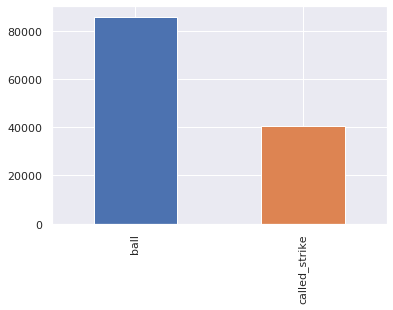

In [9]:
#visualize the target

baseball['description'].value_counts().plot(kind='bar')

# ANALYSIS

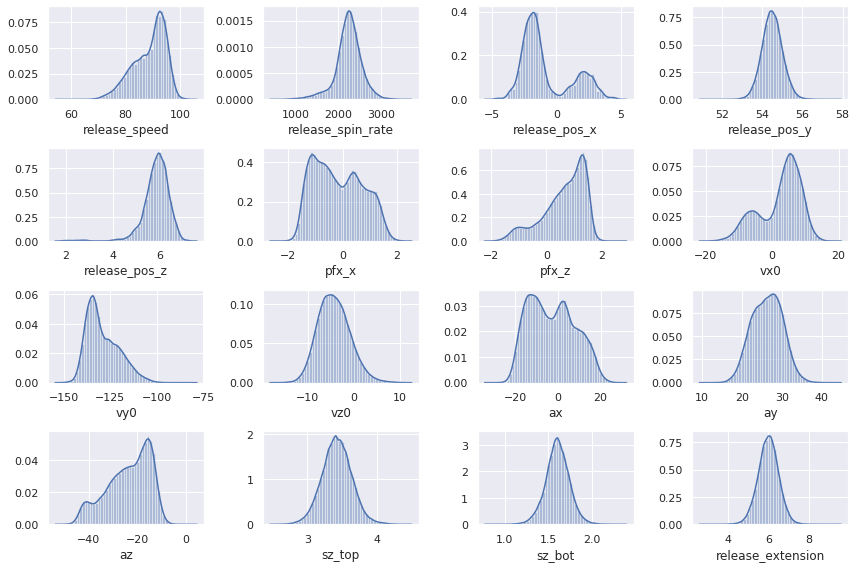

In [10]:
#visualizations

num_features_to_plot = ['release_speed', 'release_spin_rate', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'release_extension']

def plot_hist(df, features, subplot_dimensions):
    '''Input: list of feature names, list of subplot dimensions'''
    fig = plt.figure(figsize = (12, 8))
    
    for idx, feature in enumerate(list(df[features])):
        idx += 1
        plt.subplot(subplot_dimensions[0], subplot_dimensions[1], idx)
        sns.distplot(df[feature])
        idx +=1
        
        plt.tight_layout()

plot_hist(baseball, num_features_to_plot, [4,4])

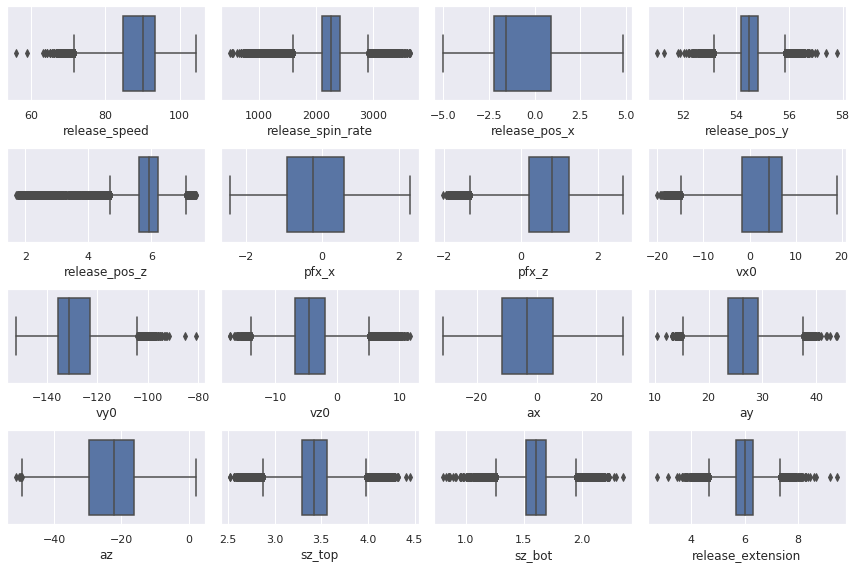

In [11]:
def plot_box(df, features, subplot_dimensions):
    '''Input: list of feature names, list of subplot dimensions'''
    fig = plt.figure(figsize = (12, 8))
    
    for idx, feature in enumerate(list(df[features])):
        idx += 1
        plt.subplot(subplot_dimensions[0], subplot_dimensions[1], idx)
        sns.boxplot(df[feature])
        idx +=1
        
        plt.tight_layout()

plot_box(baseball, num_features_to_plot, [4,4])

# DO MORE EDA HERE

Look at Categorical feature



In [12]:
baseball['pitch_name'].value_counts()

4-Seam Fastball    44538
Slider             19682
2-Seam Fastball    14248
Sinker             12686
Changeup           11497
Curveball          11265
Cutter              7455
Knuckle Curve       3198
Split Finger        1917
Eephus                12
Name: pitch_name, dtype: int64

2 Things: Don't need Euphus, and can consider Knuckle Curve as Curveball

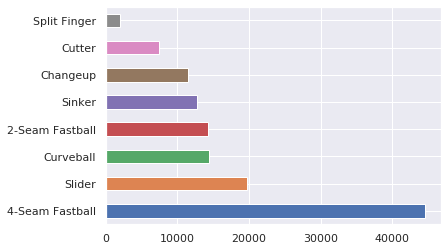

In [13]:
baseball = baseball[baseball.pitch_name != 'Eephus']

baseball['pitch_name'] = baseball['pitch_name'].replace('Knuckle Curve', 'Curveball')
baseball['pitch_name'].value_counts().plot(kind='barh')

## Baseline Logistic Regression Pipeline

Build the pipeline for Logistic Regression.

Need to get numeric values for target.

Will need to one-hot encode the categroical varaible.



In [15]:
result = baseball['description'].copy()
result = result.replace({'ball':0, 'called_strike':1})

baseball = pd.get_dummies(baseball.iloc[:, :-1], prefix = 'Pitch')
baseball.head()

,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,...,sz_bot,release_extension,Pitch_2-Seam Fastball,Pitch_4-Seam Fastball,Pitch_Changeup,Pitch_Curveball,Pitch_Cutter,Pitch_Sinker,Pitch_Slider,Pitch_Split Finger
0,95.1,2314.0,3.2655,54.4995,5.2575,1.7213,0.4271,-9.8035,-138.1130,0.1339,...,1.5059,6.001,1,0,0,0,0,0,0,0
1,96.7,2324.0,3.1728,54.3094,5.3966,0.9349,1.0015,-9.0084,-140.5865,-2.4218,...,1.5730,6.191,0,1,0,0,0,0,0,0
2,80.8,2521.0,3.3517,55.0820,5.1205,-1.0168,-0.1223,-3.7285,-117.3223,1.2140,...,1.7080,5.420,0,0,0,0,0,0,1,0
3,96.2,2329.0,3.1334,54.0207,5.2136,1.3175,0.9402,-12.0533,-139.3669,-5.1407,...,1.5639,6.479,0,1,0,0,0,0,0,0
4,96.5,2437.0,3.3033,54.3597,5.0589,1.2794,0.7425,-14.0287,-139.8559,-3.3434,...,1.6241,6.141,0,1,0,0,0,0,0,0


In [17]:
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix


#split the data into training and testing splits
X_train, X_test, y_train, y_test = train_test_split(baseball, 
                                                    result, 
                                                    random_state = 2019, test_size = .15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 random_state=2019, test_size=.2)
X_train.columns

Index(['release_speed', 'release_spin_rate', 'release_pos_x', 'release_pos_y',
       'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'sz_top', 'sz_bot', 'release_extension', 'Pitch_2-Seam Fastball',
       'Pitch_4-Seam Fastball', 'Pitch_Changeup', 'Pitch_Curveball',
       'Pitch_Cutter', 'Pitch_Sinker', 'Pitch_Slider', 'Pitch_Split Finger'],
      dtype='object')

In [18]:
#pipeline for logistic regression
#only apply StandardScaler() to numeric features

#define numeric features for custom transformation:
numeric_features = ['release_speed', 'release_spin_rate', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'release_extension']

#establish numeric pipeline steps; just use StandardScaler()
num_pipe = Pipeline(steps = [
    ('scale', StandardScaler())
])

#create column transformer
transformer = ColumnTransformer(transformers = [
    ('num', num_pipe, numeric_features),
])

#combine the column transformer with random oversampler  
#and logistic regression model to form final pipeline
pipe_lg = make_pipeline(
    transformer,
    RandomOverSampler(ratio = 1, random_state=2019),
    LogisticRegression()
)

In [19]:
#fit to training data
pipe_lg.fit(X_train, y_train)


/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['release_speed', 'release_sp...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [20]:
y_pred = pipe_lg.predict(X_val)

print(classification_report_imbalanced(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.56      0.60      0.64      0.58      0.33     14637
          1       0.39      0.60      0.56      0.47      0.58      0.34      6866

avg / total       0.63      0.57      0.59      0.59      0.58      0.33     21503

[[8183 6454]
 [2760 4106]]


## Interpretation of Logistic Regression.

## Baseline Decision Tree Pipeline

Apply same principles from Logistic Regression to a decision tree. Since decision tree has less statistical assumptions than Logistic Regression, we don't have to standardize our data here.


Balance out data here too

In [26]:
X_train_rs, y_train_rs = RandomOverSampler(ratio = 1, random_state=2019).fit_resample(X_train, y_train)

In [34]:
tree = DecisionTreeClassifier(max_depth=4)

tree.fit(X_train_rs, y_train_rs)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
y_pred_dt = tree.predict(X_val)

print(classification_report_imbalanced(y_val, y_pred_dt))
print()
print(confusion_matrix(y_val, y_pred_dt))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.57      0.58      0.65      0.58      0.33     14637
          1       0.39      0.58      0.57      0.46      0.58      0.33      6866

avg / total       0.63      0.57      0.58      0.59      0.58      0.33     21503


[[8382 6255]
 [2895 3971]]


In [30]:
X_train.columns

Index(['release_speed', 'release_spin_rate', 'release_pos_x', 'release_pos_y',
       'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'sz_top', 'sz_bot', 'release_extension', 'Pitch_2-Seam Fastball',
       'Pitch_4-Seam Fastball', 'Pitch_Changeup', 'Pitch_Curveball',
       'Pitch_Cutter', 'Pitch_Sinker', 'Pitch_Slider', 'Pitch_Split Finger'],
      dtype='object')

### Visualize the tree

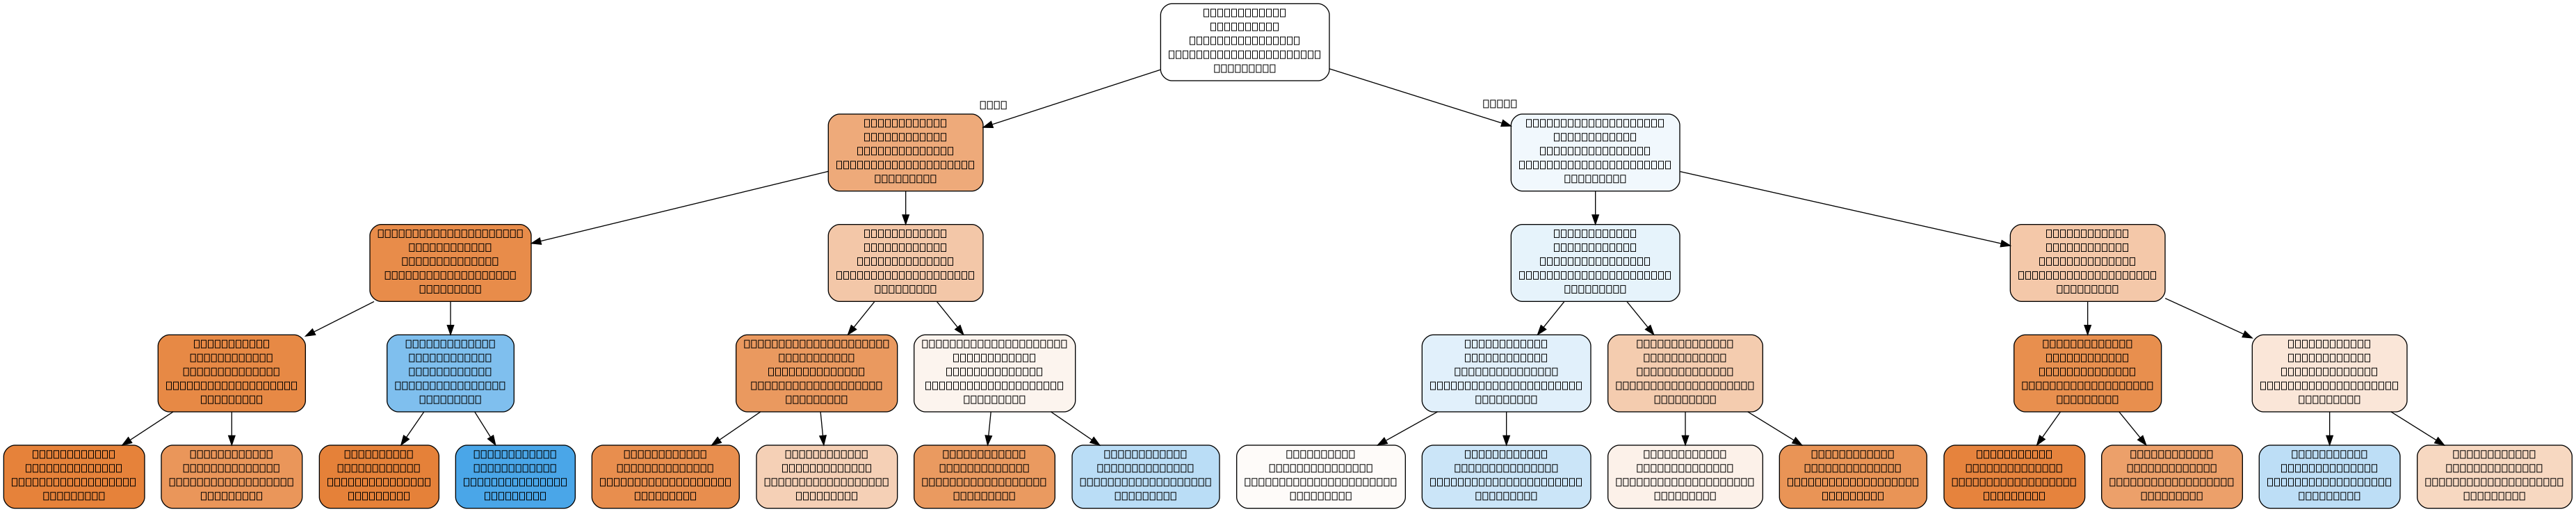

In [36]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

features = ['release_speed', 'release_spin_rate', 'release_pos_x', 'release_pos_y',
       'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'sz_top', 'sz_bot', 'release_extension', 'Pitch_2-Seam Fastball',
       'Pitch_4-Seam Fastball', 'Pitch_Changeup', 'Pitch_Curveball',
       'Pitch_Cutter', 'Pitch_Sinker', 'Pitch_Slider', 'Pitch_Split Finger']

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('baseball_tree.png')
Image(graph.create_png())
